# VH Analysis Neos setup

In [1]:
########-----------------Neos imports
from jax.example_libraries import stax  # neural network library for JAX
from jax.random import PRNGKey  # random number generator
import jax.numpy as jnp  # JAX's numpy
import neos  # :)

#Neos experiments
from neos.experiments.nn_observable import (
    nn_summary_stat,  # create a summary statistic from a neural network
    make_model,  # use the summary statistic to make a HistFactory style model
    generate_data,  # generates gaussian blobs to feed into the nn
    first_epoch,  # special plotting callback for the first epoch
    last_epoch,  # special plotting callback for the last epoch
    per_epoch,  # generic plotting callback for each epoch
    plot_setup,  # inital setup for the plotting
)

########-----------------Analysis imports
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle
import pandas as pd

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl

########-----------------Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('../others/xsec.json') as f:
    xs = json.load(f)

with open('../others/pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

mc = ['QCD','Wjets','Zjets','ttbar','singlet','VV','ggF','VBF','ZH','WH']


########-----------------To calculate significance
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

########-----------------CUSTOMIZED PARAMETERS
year = str(2017)
working_dir = '/jennet_dir/hbb-prod-modes/vh-dec-2021/'
rng_state = 0  # random state


########-----------------Get data

## 1. Preprocessing

In [2]:
qcd = np.load('qcd.npy')
sig = np.load('sig.npy')
qcd_shift_1 = np.load('qcd_shift_1.npy')
qcd_shift_2 = np.load('qcd_shift_2.npy')

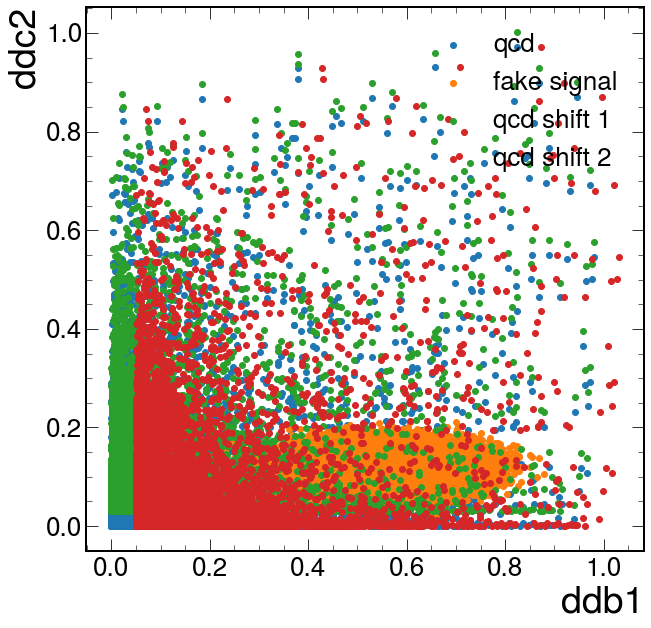

In [3]:
plt.scatter(qcd[:,0], qcd[:,1], label = 'qcd')
plt.scatter(sig[:,0], sig[:,1], label = 'fake signal')

plt.scatter(qcd_shift_1[:,0], qcd_shift_1[:,1], label = 'qcd shift 1')
plt.scatter(qcd_shift_2[:,0], qcd_shift_2[:,1], label = 'qcd shift 2')

plt.xlabel('ddb1')
plt.ylabel('ddc2')

plt.legend()
plt.show()

* Cross section
* Event weights
* 

## 2. Create custom pipeline

In [4]:
#Use simple neural net
init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

_, init_pars = init_random_params(PRNGKey(rng_state), (-1, 2))

In [5]:
p = neos.Pipeline(
    data= (sig, qcd, qcd_shift_1,qcd_shift_2),  # total number of points
    yield_kwargs=dict(
        bandwidth=1e-1,  # bandwidth of the KDE (lower = more like a real histogram)
        bins=jnp.linspace(0, 1, 5),  # binning of the summary stat (over [0,1])
    ),
    nn=nn,  # the nn we defined above
    loss=lambda x: x[
        "CLs"  # our chosen loss metric!
    ],  # you can compose your own loss from a dict of metrics (see p.possible_metrics)
    num_epochs=1,  # number of epochs
    batch_size=5000,  # number of points per batch
    plot_name="vh_toy.pdf",  # save the final plot!
    animate=True,  # make cool animations!
    animation_name="vh_toy.gif",  # save them!
    random_state=rng_state,
    yields_from_pars=nn_summary_stat,
    model_from_yields=make_model,
    init_pars=init_pars,
    first_epoch_callback=first_epoch,
    last_epoch_callback=last_epoch,
    per_epoch_callback=per_epoch,
    plot_setup=plot_setup,
)

epoch 0/1: 16 batches
batch 16/16 took 5.3040s.

batch loss: 2.37e-07
metrics evaluated on test set:
yields:
  s = [19.5, 0.474, 0, 0]
  b = [0.655, 1.62, 97.7, 0]
  bup = [0.655, 1.7, 97.7, 0]
  bdown = [0.755, 2.51, 96.7, 0]
CLs = 3.91e-09
mu_uncert = 0.0415
pull_width = 0.952
1-pull_width**2 = 0.00233
pull = 0.0877
loss = 3.91e-09



(<matplotlib.animation.ArtistAnimation at 0x7f14a1d7bbb0>,
 {'CLs': [DeviceArray(1.26580072e-07, dtype=float64),
   DeviceArray(1.29573704e-07, dtype=float64),
   DeviceArray(9.85711122e-08, dtype=float64),
   DeviceArray(8.5580167e-08, dtype=float64),
   DeviceArray(7.34543832e-08, dtype=float64),
   DeviceArray(6.55590278e-08, dtype=float64),
   DeviceArray(6.76900787e-08, dtype=float64),
   DeviceArray(4.84220175e-08, dtype=float64),
   DeviceArray(2.61305764e-08, dtype=float64),
   DeviceArray(1.42449139e-08, dtype=float64),
   DeviceArray(8.96790775e-09, dtype=float64),
   DeviceArray(6.54734089e-09, dtype=float64),
   DeviceArray(5.24428656e-09, dtype=float64),
   DeviceArray(4.50257609e-09, dtype=float64),
   DeviceArray(3.91663257e-09, dtype=float64),
   DeviceArray(3.91443522e-09, dtype=float64)],
  'mu_uncert': [DeviceArray(0.09659537, dtype=float64),
   DeviceArray(0.09691283, dtype=float64),
   DeviceArray(0.09091519, dtype=float64),
   DeviceArray(0.08731105, dtype=float64

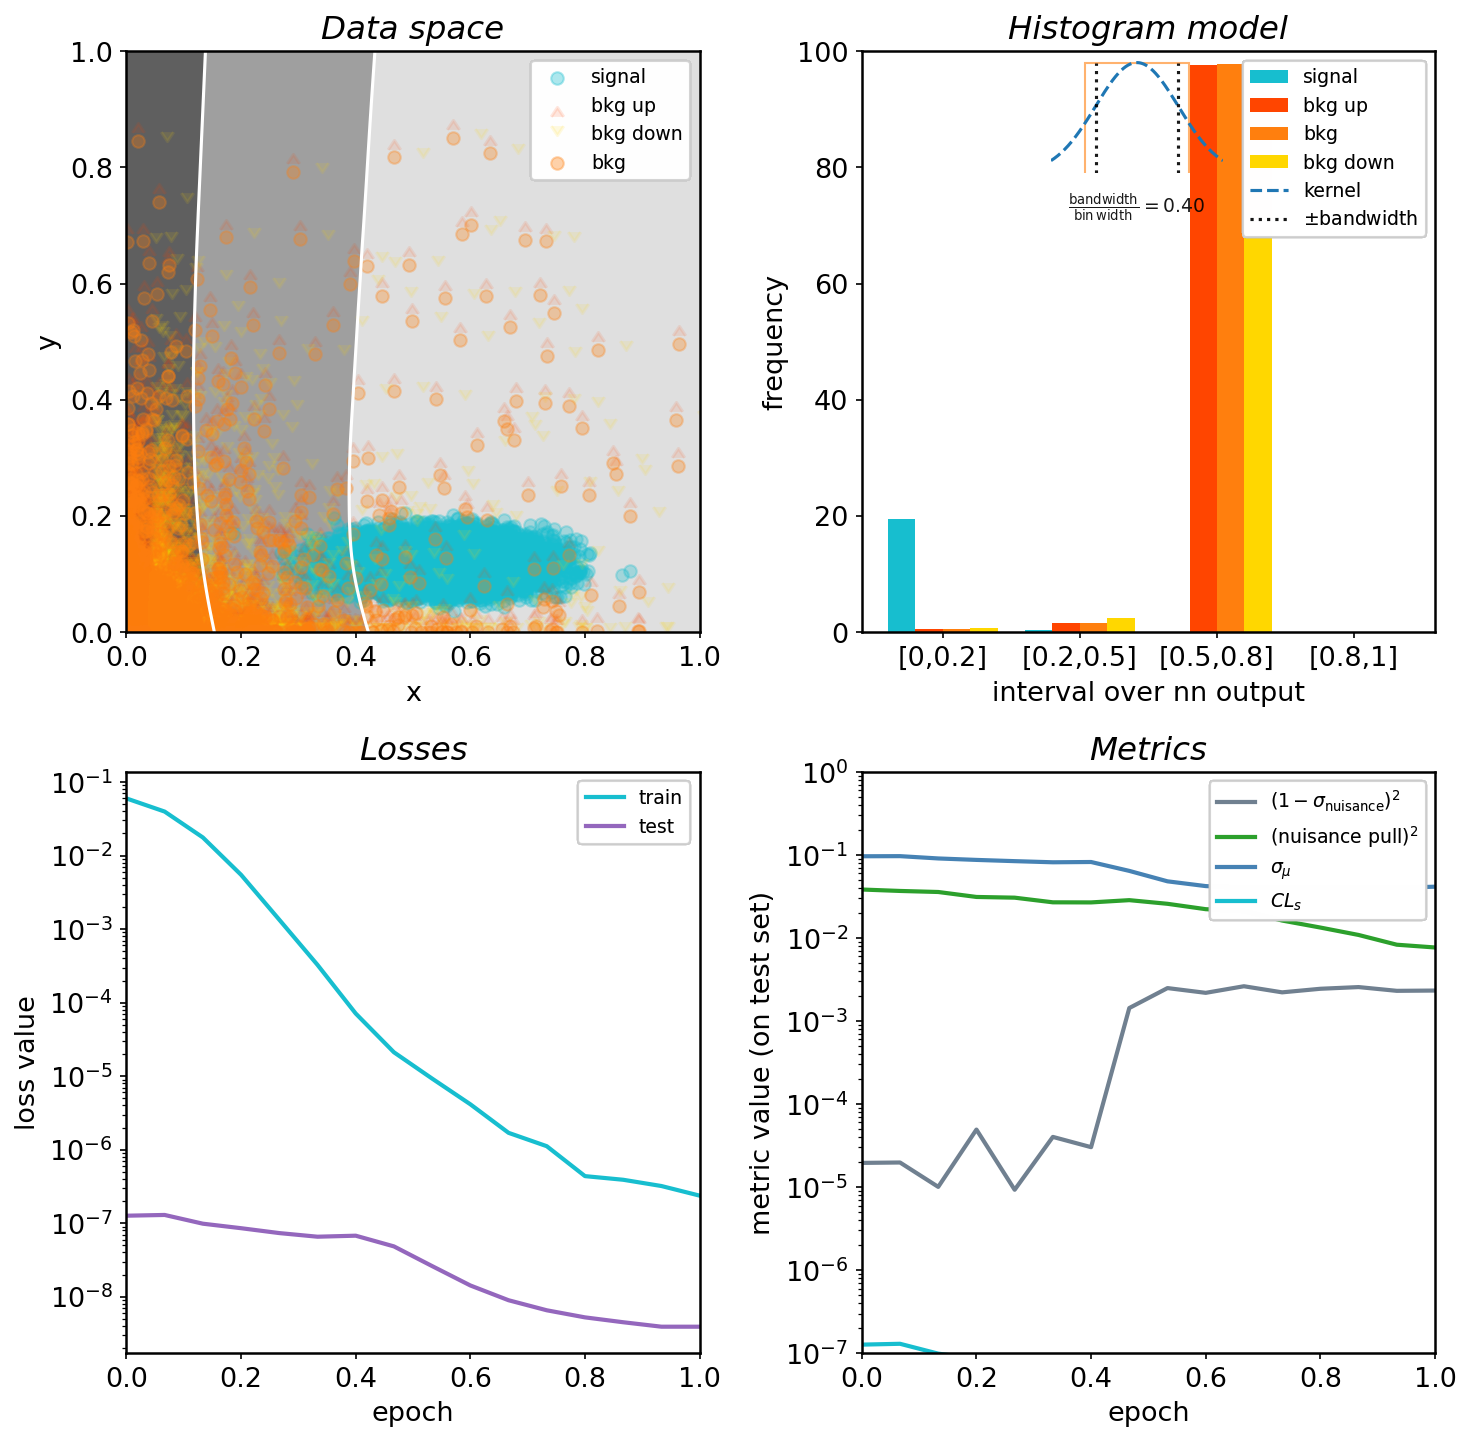

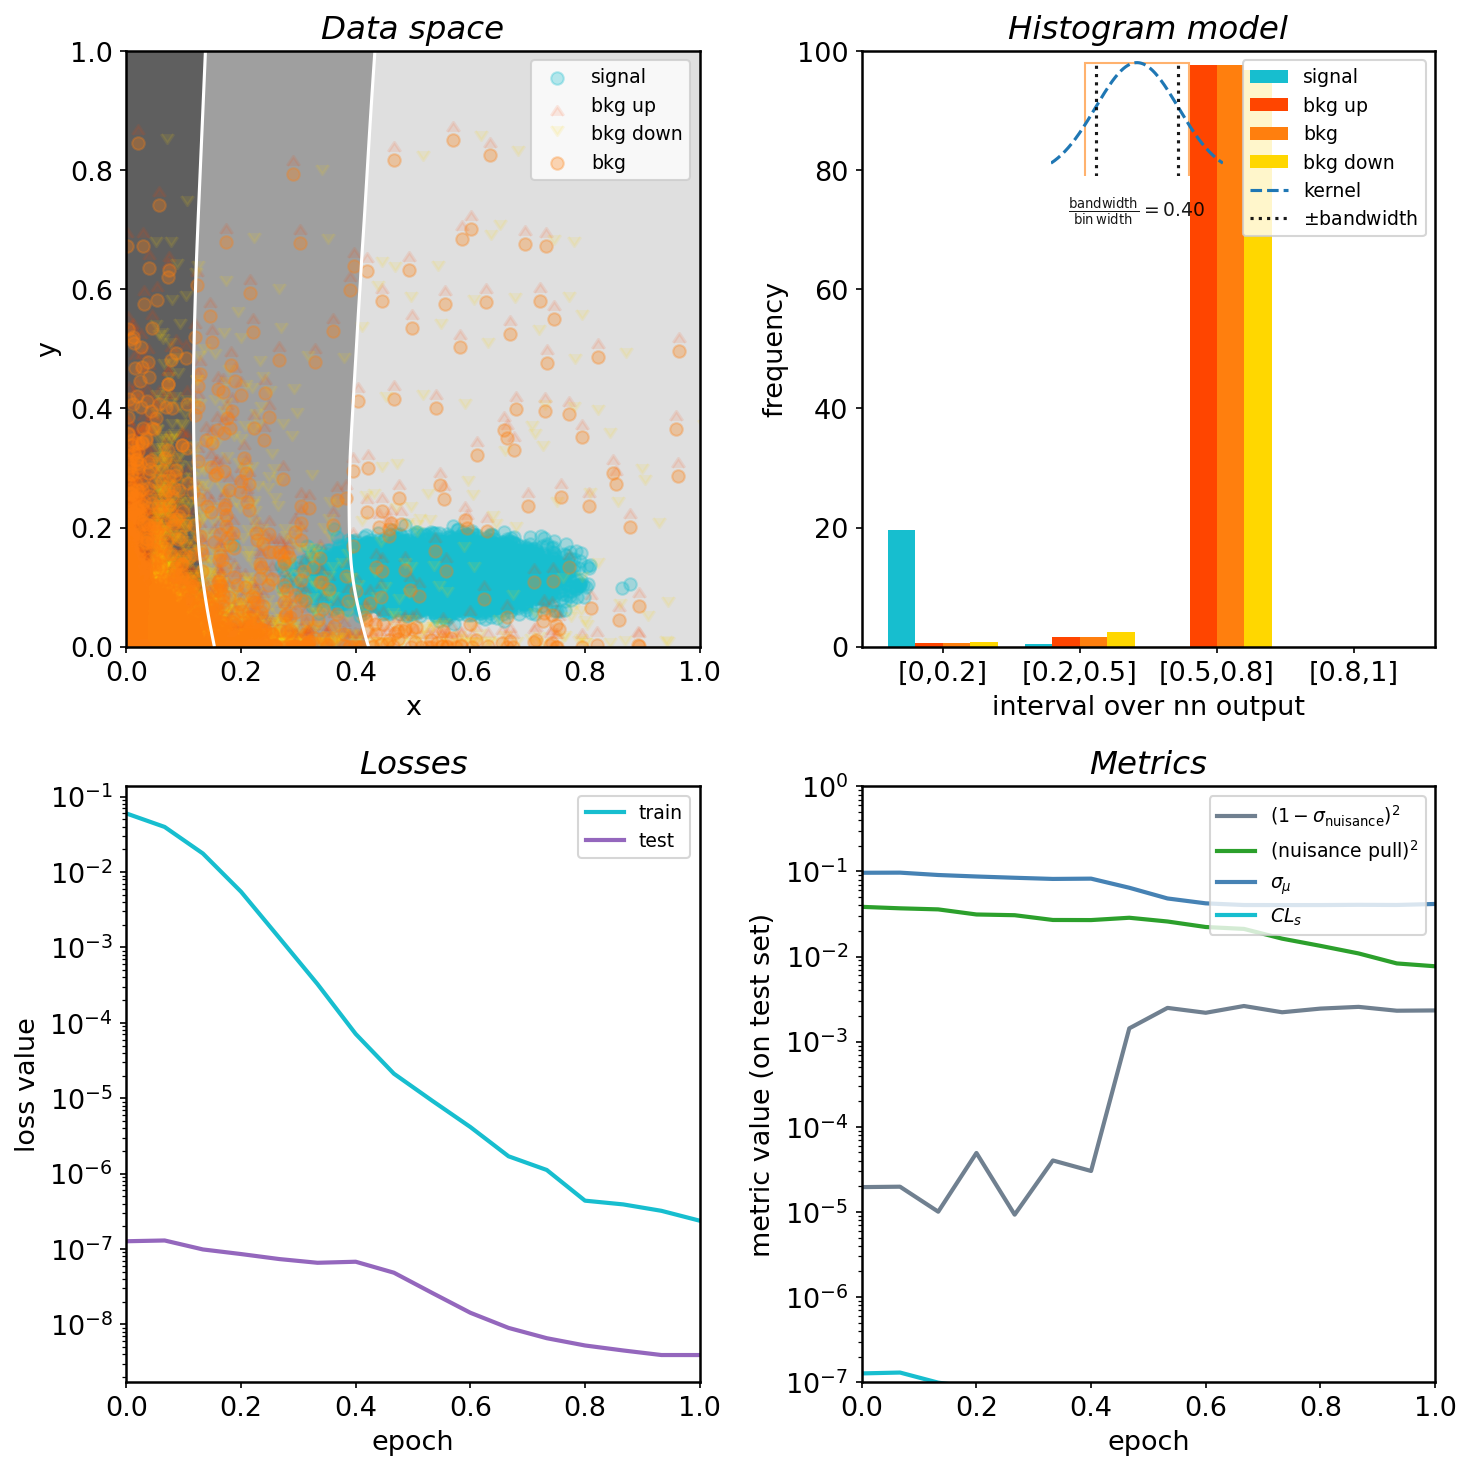

In [6]:
p.run()

### TODO:

- Generate data for pipeline:
    * For now using only QCD as backgrounds, ZH or WH data points as signals. 10000 data points each.

In [8]:
!ls /jennet_dir/hbb-prod-modes/vh-dec-2021/

2016		  make-hists-1mv-charm.py   outfiles
2017		  make-hists-1mv-charm.py~  outfiles-beforeXmas
2018		  make-hists-1mv-light.py   plot-vh.ipynb
README.md	  make-hists-1mv-light.py~  pmap.json
README.md~	  make-hists-1mv.py	    pmap_mc.json
boostedhiggs	  make-hists-1mv.py~	    shell
dask-report.html  make-hists-3mv-charm.py   submit-dask.py
draw_datafit.C	  make-hists-3mv-light.py   triggers.json
draw_datafit.C~   make-hists-3mv.py	    vh-scripts
infiles		  make-pkl.py		    xsec.json
jupyter.sh	  muon_triggers.json


In [ ]:
#Use simple neural net
init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

_, init_pars = init_random_params(PRNGKey(rng_state), (-1, 2))

## 2. Create custom pipeline

In [ ]:
p = neos.Pipeline(
    data=generate_data(rng=rng_state, num_points=10000),  # total number of points
    yield_kwargs=dict(
        bandwidth=1e-1,  # bandwidth of the KDE (lower = more like a real histogram)
        bins=jnp.linspace(0, 1, 5),  # binning of the summary stat (over [0,1])
    ),
    nn=nn,  # the nn we defined above
    loss=lambda x: x[
        "CLs"  # our chosen loss metric!
    ],  # you can compose your own loss from a dict of metrics (see p.possible_metrics)
    num_epochs=5,  # number of epochs
    batch_size=2000,  # number of points per batch
    plot_name="demo_nn_observable.png",  # save the final plot!
    animate=True,  # make cool animations!
    animation_name="demo_nn_observable.gif",  # save them!
    random_state=rng_state,
    yields_from_pars=nn_summary_stat,
    model_from_yields=make_model,
    init_pars=init_pars,
    first_epoch_callback=first_epoch,
    last_epoch_callback=last_epoch,
    per_epoch_callback=per_epoch,
    plot_setup=plot_setup,
)